## BLIP: Convert image-to-caption using BLIP and merge with csv
Possible improvements:
- remove/modify conditional prompting?
- add in more features? (colors, styles of the picture(ad?), etc.)
- different text to image models?

In [92]:
%pip install -U sentence-transformers

In [93]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import statsmodels.api as sm
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


nltk.download('stopwords')
nltk.download('wordnet')

csv_path = '/content/drive/MyDrive/Colab Notebooks/Data/instagram_data.csv'
updated_csv_path = '/content/drive/MyDrive/Colab Notebooks/Data/updated_file.csv'

# Load the existing CSV file and resume processing
if os.path.exists(updated_csv_path):
    # If an updated CSV exists, resume processing from there
    df = pd.read_csv(updated_csv_path)
else:
    # If no updated CSV exists, start fresh
    df = pd.read_csv(csv_path)
    # Add an empty 'captions' column for storing generated captions
    df['captions'] = ""

# Initialize the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

# Define a text prompt (for conditional captioning)
text_prompt = "a photography of"

for index, row in df.iterrows():
    # Skip rows that already have captions
    if pd.notna(row['captions']) and row['captions'] != "":
        continue

    image_path = row['image_path']
    full_image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Data', image_path)

    if os.path.exists(full_image_path):
        raw_image = Image.open(full_image_path).convert('RGB')

        # Process the image with the processor
        inputs = processor(raw_image, text_prompt, return_tensors="pt").to("cuda")

        # Generate the caption using the model
        out = model.generate(**inputs)

        # Decode the output to get the text caption
        caption = processor.decode(out[0], skip_special_tokens=True)
        df.at[index, 'captions'] = caption

        if index % 10 == 0:
            df.to_csv(updated_csv_path, index=False)
            print(f"Processed {image_path}: {caption}")
    else:
        print(f"Image not found at {full_image_path}")
        df.at[index, 'captions'] = "Image not found"

# Final save
df.to_csv(updated_csv_path, index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [94]:
df = pd.read_csv(updated_csv_path)
df.head()

,likes,no_of_comments,t,follower_count_at_t,image_path,captions
0,154552,0,1594174009,40934474,../Data/insta_data/0.jpg,a photography of a couple standing in front of...
1,97386,0,1593571666,40934474,../Data/insta_data/2.jpg,a photography of a woman sitting on a chair wi...
2,145632,0,1593136341,40934474,../Data/insta_data/4.jpg,a photography of a woman standing on a porch h...
3,76461,0,1592981047,40934474,../Data/insta_data/6.jpg,a photography of three people standing in fron...
4,174620,0,1592703461,40934474,../Data/insta_data/8.jpg,a photography of a man in a black suit talking...


In [95]:
# remove text_prompt, lowercase, remove punctuation, lemmatization, and remove stopwords
lemmatizer = WordNetLemmatizer()
def clean(captions):
    captions = captions.replace(text_prompt, '')
    captions = captions.lower()
    captions = re.sub('[^a-zA-Z0-9- ]+', '', captions)
    captions = " ".join([lemmatizer.lemmatize(word) for word in captions.split()
                         if word not in stopwords.words('english')])

    return captions
df['captions'] = df['captions'].apply(clean)

df['log_likes'] = np.log(df['likes'] + 1)
df['log_comments'] = np.log(df['no_of_comments'] + 1)
df['log_followers'] = np.log(df['follower_count_at_t'] + 1)

# remove timestamp, and image_path
df.drop(['t', 'image_path'], axis=1, inplace=True)

df.head()

,likes,no_of_comments,follower_count_at_t,captions,log_likes,log_comments,log_followers
0,154552,0,40934474,couple standing front green purple theme,11.948292,0.0,17.527483
1,97386,0,40934474,woman sitting chair handbag,11.486448,0.0,17.527483
2,145632,0,40934474,woman standing porch holding bag,11.888845,0.0,17.527483
3,76461,0,40934474,three people standing front green wall,11.244549,0.0,17.527483
4,174620,0,40934474,man black suit talking cell phone,12.070373,0.0,17.527483


### EDA: Numeric Data
Insight:
- From the plot, we can observe that likes and comments seem to have a positive correlation
- The followers shows two portion distributions, may mean there exist two different groups of people one with extremely more followers (celebrities) and one less followers (ordinary people)

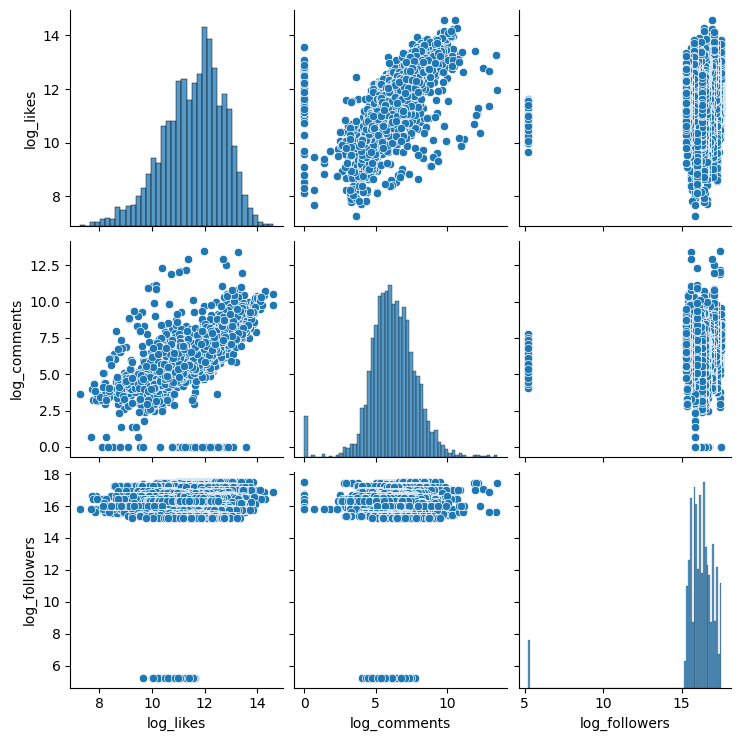

In [96]:
sns.pairplot(df.drop(['likes', 'no_of_comments', 'follower_count_at_t', 'captions'], axis=1))

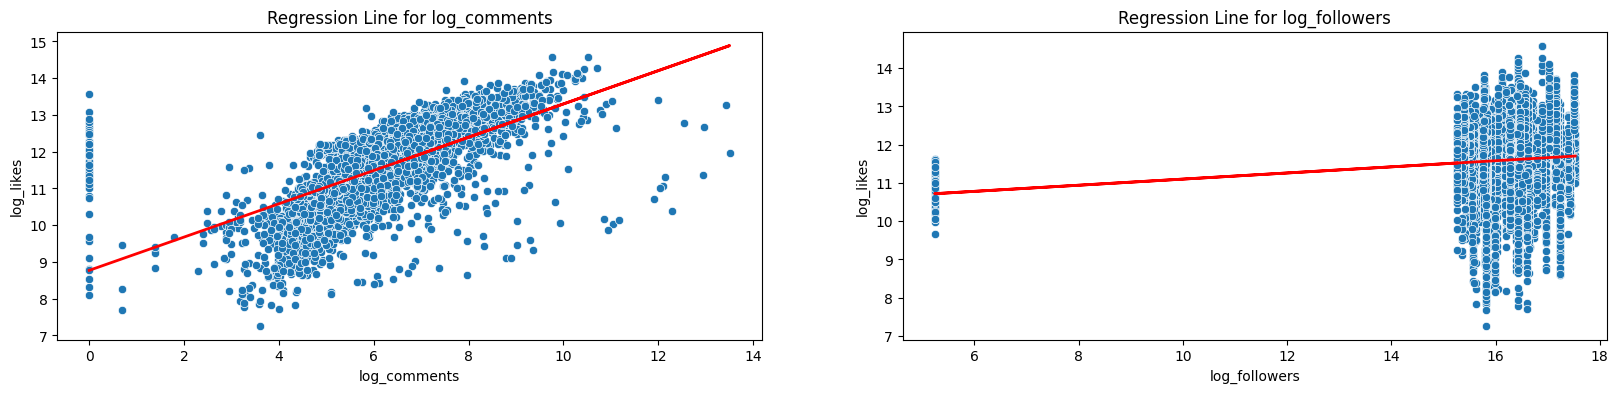

In [97]:
features = df.columns.drop(['likes', 'log_likes', 'no_of_comments', 'follower_count_at_t', 'captions'])
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

for i, feature in enumerate(features):
    X = df[[feature]]
    y = df['log_likes'] # use log likes to correct skewness

    X = sm.add_constant(X)  # Adding constant (intercept)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Plotting scatterplot and regression line
    sns.scatterplot(x=X[feature], y=y, ax=axes[i])
    axes[i].plot(X[feature], model.predict(X), color='red', linewidth=2)
    axes[i].set_title(f"Regression Line for {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('log_likes')

plt.show()

Insight:
- **R-squared = 0.436:** Only 43.6% of the variance in likes is explained by the features, this suggests a moderate fit, there's still a significant portion of the variance not explained by the the two numeric features.
- **P-Values**: Both features show a statistically significance to "likes", however, from the second plot previously and the small coefficients for followers, we can not make a definite statement between followers and likes.

In [98]:
X = df[['log_comments', 'log_followers']]
y = df['log_likes']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_likes   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     1459.
Date:                Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:38:58   Log-Likelihood:                -4783.0
No. Observations:                3785   AIC:                             9572.
Df Residuals:                    3782   BIC:                             9591.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.8383      0.146     53.686

### EDA: Caption
#### Term Frequency
Insight: Looks like the term "woman" appear much more frequently comparing to "man" in this dataset

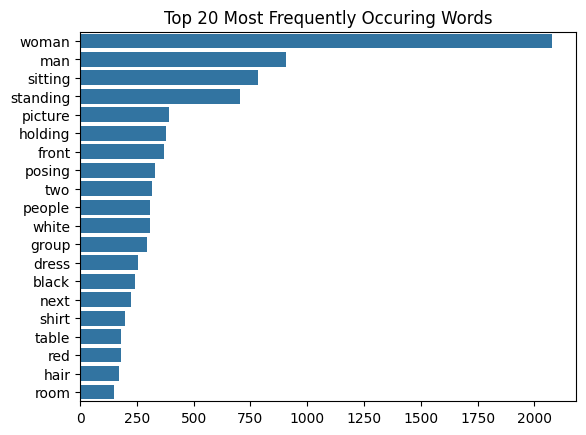

In [99]:
def corpus(text):
    text_list = text.split()
    return text_list
df['corpuses'] = df['captions'].apply(corpus)

corpus = []
for i in range(df.shape[0]):
    corpus += df['corpuses'][i]
mostCommon = Counter(corpus).most_common(20)

words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Top 20 Most Frequently Occuring Words')
plt.show()

### Sentence to embedding

In [100]:
model = SentenceTransformer('moka-ai/m3e-base').to("cuda")

captions = df['captions'].tolist()
embeddings = model.encode(captions, convert_to_tensor=True, show_progress_bar=True).to("cuda")
embeddings_df = pd.DataFrame(embeddings.cpu().numpy())
combined_df = pd.concat([embeddings_df, df[['log_likes', 'log_comments', 'log_followers']].reset_index(drop=True)], axis=1)

combined_df.head()

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,log_likes,log_comments,log_followers
0,0.286888,0.463156,0.483880,-0.487039,0.024606,-0.898779,0.004700,0.487875,-0.506306,0.042186,...,0.050319,0.677771,-0.770296,-0.191577,-1.111942,-1.209238,-0.473028,11.948292,0.0,17.527483
1,0.548910,1.040525,-0.059623,-0.582735,-0.147561,-1.440308,-0.062373,0.364399,-1.001483,0.333850,...,0.256037,0.297955,-0.774801,0.097452,-1.530750,-0.523161,-0.693957,11.486448,0.0,17.527483
2,0.343293,0.683803,1.298113,-0.189648,0.768727,-0.547514,-0.450462,0.607971,-0.618579,-0.193399,...,-0.727765,0.490836,-0.436799,-0.479937,-1.185098,-0.771812,-0.664034,11.888845,0.0,17.527483
3,-0.280840,-0.440371,0.290392,-0.507593,-0.534275,-1.082535,0.205656,0.610149,-0.892198,0.578041,...,-0.044799,1.309021,-0.935084,-0.387392,-1.267260,-1.250148,-0.472429,11.244549,0.0,17.527483
4,0.962333,0.157692,0.727231,0.283707,0.187263,-1.374051,-0.117907,0.570724,-1.628946,0.373418,...,-0.662264,0.680463,-0.730470,-0.625506,-1.081291,-0.473355,0.118574,12.070373,0.0,17.527483


### Normalizing

In [101]:
X = combined_df.drop(columns=['log_likes'])
X.columns = X.columns.astype(str) # convert column name to str type to avoid error
y = combined_df['log_likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Training

In [102]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

results = []
for model_name, model_instance in models.items():
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)

    results.append({
        "Model": model_name,
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred) ** 0.5,
        "R-squared": r2_score(y_test, y_pred)
    })

In [104]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to("cuda")
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to("cuda")  # (N, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cuda")
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to("cuda")

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512) # input
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(128, 1)  # output

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(torch.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x

input_dim = X_train.shape[1]  # Number of input features
dnn_model = RegressionNN(input_dim).to("cuda")
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(dnn_model.parameters(), lr=0.001)

epochs = 1000
for epoch in range(epochs):
    dnn_model.train()
    optimizer.zero_grad()
    predictions = dnn_model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

dnn_model.eval()
with torch.no_grad():
    predictions_test = dnn_model(X_test_tensor).cpu().numpy()

# Convert predictions to 1D array
predictions_test = predictions_test.flatten()

results.append({
    "Model": "DNN",
    "MSE": mean_squared_error(y_test, predictions_test),
    "MAE": mean_absolute_error(y_test, predictions_test),
    "RMSE": mean_squared_error(y_test, predictions_test)**0.5,
    "R-squared": r2_score(y_test, predictions_test)
})
results_df = pd.DataFrame(results)
print(results_df)

                       Model       MSE       MAE      RMSE  R-squared
0          Linear Regression  0.877306  0.709819  0.936646   0.341491
1           Ridge Regression  0.868621  0.706213  0.931999   0.348010
2           Lasso Regression  1.332298  0.941401  1.154252  -0.000027
3              Decision Tree  0.848902  0.659627  0.921359   0.362812
4              Random Forest  0.440257  0.493934  0.663518   0.669542
5          Gradient Boosting  0.360684  0.441741  0.600570   0.729269
6  Support Vector Regression  0.816504  0.709974  0.903606   0.387129
7                        DNN  0.679408  0.643251  0.824262   0.490034
